In [2]:
import yaml
import pymongo
import json
from urllib.parse import quote_plus as quote
import numpy as np


In [3]:
# Подключимся к нашей коллекции

with open('../../creds.yaml', 'r') as file:
    creds_dict = yaml.safe_load(file)
    
url = 'mongodb://{user}:{pw}@{hosts}/?{rs}&authSource={auth_src}&{am}&tls=true&tlsCAFile={cert_file}'.format(
    user=creds_dict['username'],
    pw=quote(creds_dict['password']),
    hosts=creds_dict['host'],
    rs='replicaSet=rs01',
    auth_src=creds_dict['database'],
    am='authMechanism=DEFAULT',
    cert_file='../../root.crt'
    )

dbs = pymongo.MongoClient(url)

db = dbs[creds_dict['database']]

collection = db['initial_dataset']

In [4]:
# Пример aggregation pipeline - чтобы достать только нужные поля из Mongo
pipeline = [{ "$unwind" : "$data_result.boxes" },
            {"$project":{
                "mass": "$data_result.boxes.mass",
                "size": "$data_result.boxes.size",
                "stacking": "$data_result.boxes.stacking",
                "turnover": "$data_result.boxes.turnover",
                "stacking_limit": "$data_result.boxes.stacking_limit",
                "loading_size": "$data_result.cargo_space.loading_size",
                "density_percent": "$data_result.cargo_space.calculation_info.density_percent",
                "filling_space_percent": "$data_result.cargo_space.calculation_info.filling_space_percent",
                }},
            {"$group": {"_id": "$_id",
                        "loading_size": {"$first":"$loading_size"},
                        "density_percent": {"$first":"$density_percent"},
                        "filling_space_percent": {"$first":"$filling_space_percent"},
                        "boxes": {
                            "$push":  {
                                "mass": "$mass",
                                "size": "$size",
                                "stacking": "$stacking",
                                "turnover": "$turnover",
                                "stacking_limit": "$stacking_limit"                        
                            }
                            
                        }
            }
            }
            ]
result = collection.aggregate(pipeline)
#item = result.next()
#print(item)
dataset = [i for i in result]

In [5]:
len(dataset)

628

In [6]:
type(dataset)

list

In [7]:
type(dataset[0])

dict

In [8]:
target_array =  []
for data in dataset:
    target_array.append(data['filling_space_percent']/100)
    del data['filling_space_percent']
    del data['density_percent']

In [9]:
target_array[1]

0.1225662

In [10]:
source_array = []
for data in dataset:
    source_array_1 = [[],[],[],[],[]]
    for box in data['boxes']:
        source_array_1[0].append(box['size']['length'])
        source_array_1[1].append(box['size']['width'])
        source_array_1[2].append(box['size']['height'])
        source_array_1[3].append(int(box['stacking']))
        source_array_1[4].append(int(box['turnover']))
    source_array.append(source_array_1)

In [11]:
length = max(map(len, source_array))
for arr in source_array:
    if (max(map(len, arr)) > length):
        length = max(map(len, arr))
length

2849

In [12]:
X = []
for arr in source_array:
    X.append(np.array([xi+[0]*(length-len(xi)) for xi in arr]))

source = np.array(X)

In [13]:
source.shape

(628, 5, 2849)

In [14]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Flatten, Reshape
import matplotlib.pyplot as plt

In [15]:
def one_plot(n, y_lb, loss_acc, val_loss_acc):
    plt.subplot(1, 2, n)
    if n == 1:
        lb, lb2 = 'loss', 'val_loss'
        yMin = 0
        yMax = 1.05 * max(max(loss_acc), max(val_loss_acc))
    else:
        lb, lb2 = 'mean_squared_error', 'val_mean_squared_error'
        yMin = min(min(loss_acc), min(val_loss_acc))
        yMax = 1.0
    plt.plot(loss_acc, color = 'r', label = lb, linestyle = '--')
    plt.plot(val_loss_acc, color = 'g', label = lb2)
    plt.ylabel(y_lb)
    plt.xlabel('Эпоха')
    plt.ylim([0.95 * yMin, yMax])
    plt.legend()

In [16]:
pathToHistory = '' # G:/AM/Лекции/
suff = '.txt'
# Имена файлов, в которые сохраняется история обучения
fn_loss = pathToHistory + 'loss_' + suff
fn_acc = pathToHistory + 'acc_' + suff
fn_val_loss = pathToHistory + 'val_loss_' + suff
fn_val_acc = pathToHistory + 'val_acc_' + suff

In [17]:
X = np.asarray(source).astype(float)
Y = np.asarray(target_array).astype(float)

normalizer1 = tf.keras.layers.experimental.preprocessing.Normalization(axis=None)
normalizer1.adapt(X)

print(X.shape)
print(Y.shape)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

(628, 5, 2849)
(628,)


In [27]:
inp = Input(shape=(5, 2849, 1))
x = inp
x = Flatten()(x)
x = Dense(units = 64, activation = 'relu')(x)
x = Dense(units = 32, activation = 'relu')(x)
x = Dense(units = 16, activation = 'softsign')(x)
x = Dense(units = 8, activation = 'softmax')(x)
output = Dense(1, activation = 'softmax')(x)
model = keras.Model(inputs = inp, outputs = output)
model.summary()

model.compile(
    optimizer='Adamax',
    loss='mean_absolute_percentage_error',
    metrics=['mean_absolute_percentage_error']
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 2849, 1)]      0         
                                                                 
 flatten_3 (Flatten)         (None, 14245)             0         
                                                                 
 dense_9 (Dense)             (None, 64)                911744    
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 16)                528       
                                                                 
 dense_12 (Dense)            (None, 8)                 136       
                                                                 
 dense_13 (Dense)            (None, 1)                 9   

In [26]:
history = model.fit(x_train, y_train, batch_size = 16, epochs = 50, validation_data = (x_test, y_test))

Epoch 1/50
36/36 [==============================] - 1s 7ms/step - loss: 11591.9424 - mean_absolute_percentage_error: 11591.9424 - val_loss: 172.1478 - val_mean_absolute_percentage_error: 172.1478
Epoch 2/50
36/36 [==============================] - 0s 3ms/step - loss: 11591.9453 - mean_absolute_percentage_error: 11591.9453 - val_loss: 172.1478 - val_mean_absolute_percentage_error: 172.1478
Epoch 3/50
36/36 [==============================] - 0s 3ms/step - loss: 11591.9424 - mean_absolute_percentage_error: 11591.9424 - val_loss: 172.1478 - val_mean_absolute_percentage_error: 172.1478
Epoch 4/50
36/36 [==============================] - 0s 3ms/step - loss: 11591.9424 - mean_absolute_percentage_error: 11591.9424 - val_loss: 172.1478 - val_mean_absolute_percentage_error: 172.1478
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 11591.9424 - mean_absolute_percentage_error: 11591.9424 - val_loss: 172.1478 - val_mean_absolute_percentage_error: 172.1478
Epoch 6/50
36/36 [==

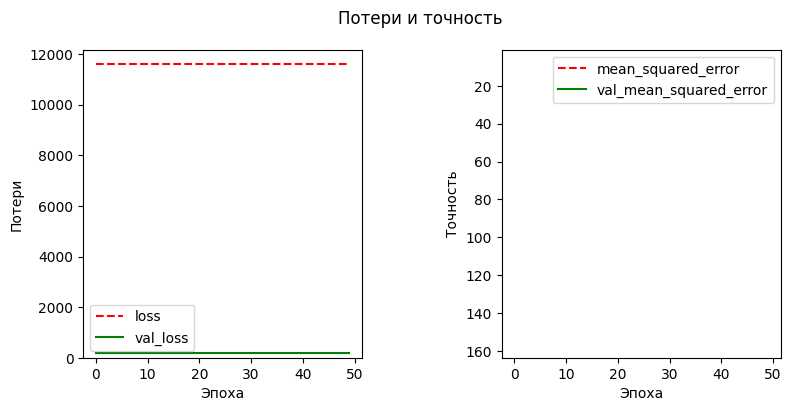

In [22]:
# Запись истории обучения в текстовые файлы
history = history.history
with open(fn_loss, 'w') as output:
    for val in history['loss']: output.write(str(val) + '\n')
with open(fn_acc, 'w') as output:
    for val in history['mean_absolute_percentage_error']: output.write(str(val) + '\n')
with open(fn_val_loss, 'w') as output:
    for val in history['val_loss']: output.write(str(val) + '\n')
with open(fn_val_acc, 'w') as output:
    for val in history['val_mean_absolute_percentage_error']: output.write(str(val) + '\n')
# Вывод графиков обучения
plt.figure(figsize = (9, 4))
plt.subplots_adjust(wspace = 0.5)
one_plot(1, 'Потери', history['loss'], history['val_loss'])
one_plot(2, 'Точность', history['mean_absolute_percentage_error'], history['val_mean_absolute_percentage_error'])
plt.suptitle('Потери и точность')
plt.show()